# Label propagation
Each organ expert group had used cellxgene to annotate celltypes from a cellxgene object. 
We read in the csv output by cellxgene (this required a little bit of manual engineering because the column names and numbers are not the same) 
Also skin was a last addition to the dataset, and is derived using a SS2 dataset rather than 10X, so the file names contain skin to differentiate it from previous versions of annotation.

# load necessary pacakges

In [1]:
import sys
import os 

sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('/data/yosef2/users/chenling/tabula-sapiens/')
import anndata

from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

from copy import deepcopy
retrain=False

import matplotlib
%matplotlib inline

# set and create directories for saving results

In [2]:
data_path = '/data/yosef2/users/chenling/TabulaSapiensData/'
model_path = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels/'
res_path = '/data/yosef2/users/chenling/TabulaSapiens/Pilot2_rerun/'

if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(model_path+'scanvi/'):
    os.mkdir(model_path+'scanvi/')
if not os.path.exists(res_path):
    os.mkdir(res_path)

# make annotation file for pilot2
This section of the notebook summarizes and concatenate the cellxgene output csv files and generate an annotation file 'Pilot2/pilot2.all.unique.skin.csv' for all Pilot2 datasets.

In [3]:
ann_path = '/data/yosef2/users/chenling/TabulaSapiensData/Pilot2/ManualAnnotation/'
ann_files = os.listdir(ann_path)
print(ann_files)

['TSP2.lung.SoRi.csv', 'TSP2.trachea.William.csv', 'TSP2.thymus.Koki.csv', 'TSP2.bladder.Aaron.csv', 'TSP2.blood.Sheela.csv', 'TSP2.lymphnode.Kimberly.csv', 'TSP2.spleen.Kimberly.csv', 'TSP2.li.Zhen.csv', 'TSP2.muscle.Antoine.csv', 'TSP2.si.Zhen.csv', 'TSP2.skin.Kimberly.csv', 'hide', 'TSP2.vasculature.Ragini.csv', 'TSP2.kidney.Gabe.csv', 'TSP2_BM_ManualAnnotation_MSwift.h5ad', 'TSP2.all.unique.csv', 'TSP2.bm.MSwift.csv']


In [4]:
pilot2_meta = pd.read_csv(data_path + 'Pilot2/pilot2.meta.csv', index_col=0)

In [5]:
annotations = {}
for x in ann_files:
    if 'csv' in x:
        print(x)
        organ = x.split('.')[1]
        if organ=='bm':
            tab = pd.read_csv(ann_path + x, index_col=0)
        else:
            tab = pd.read_csv(ann_path + x, index_col=0, skiprows=2)
        tab.index = [x.split('-')[0] for x in tab.index]
        if organ=='muscle':
            barcodes = tab.index
            unique_barcodes, count = np.unique(barcodes, return_counts=True)
            is_unique = [x in unique_barcodes[count==1] for x in barcodes]
            tab = tab.loc[is_unique]
        is_pilot2 = [x for x in tab.index if x in pilot2_meta.index]
        tab = tab.loc[is_pilot2]        
        tab = tab[[tab.columns[-1]]]
        tab.columns= ['manual_annotation']
        tab['organ'] = organ
        print(np.unique([len(x) for x in tab.index], return_counts=True))
        annotations[organ] = tab


TSP2.lung.SoRi.csv
(array([16]), array([20605]))
TSP2.trachea.William.csv
(array([16]), array([4680]))
TSP2.thymus.Koki.csv
(array([16]), array([8035]))
TSP2.bladder.Aaron.csv
(array([16]), array([10334]))
TSP2.blood.Sheela.csv
(array([16]), array([10177]))
TSP2.lymphnode.Kimberly.csv
(array([16]), array([9110]))
TSP2.spleen.Kimberly.csv
(array([16]), array([7294]))
TSP2.li.Zhen.csv
(array([16]), array([7704]))
TSP2.muscle.Antoine.csv
(array([16]), array([15689]))
TSP2.si.Zhen.csv
(array([16]), array([6273]))
TSP2.skin.Kimberly.csv
(array([78, 79, 80, 81, 82, 83, 84, 85, 86]), array([  4,  13,  27,  56,  70, 197, 190, 153, 146]))
TSP2.vasculature.Ragini.csv
(array([16]), array([7492]))
TSP2.kidney.Gabe.csv
(array([16]), array([22403]))
TSP2.all.unique.csv
(array([16]), array([132103]))
TSP2.bm.MSwift.csv
(array([16]), array([2881]))


In [6]:
ann = pd.concat([annotations[x] for x in annotations.keys() if x != 'all'], axis=0)
print(ann.shape)
barcodes = ann.index
unique_barcodes, count = np.unique(barcodes, return_counts=True)
ann = ann.loc[unique_barcodes[count==1]]
print(ann.shape)

(133533, 2)
(132961, 2)


In [126]:
ann = pd.concat([annotations[x] for x in annotations.keys() if x != 'all'], axis=0)
print(ann.shape)
barcodes = ann.index
unique_barcodes, count = np.unique(barcodes, return_counts=True)
ann = ann.loc[unique_barcodes[count==1]]
print(ann.shape)

(132677, 2)
(132105, 2)


In [7]:
ann.to_csv(data_path + 'Pilot2/pilot2.all.unique.skin.csv')

# Combining labels and unannotated filtered object
This section of the notebook matches the annotation file to unannoated combeind object from pilot1 and pilot2.

### read unannotated combined object

In [8]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.ss2_norm.embedding.h5ad')

### match 'Pilot1/pilot1.ann.csv' and 'Pilot2/pilot2.all.unique.skin.csv' to unannotated cells by their cell id. 

In [24]:
ann1 = pd.read_csv(data_path+'Pilot1/pilot1.ann.csv', index_col=0, dtype=str)
ann2 = combined.obs.loc[combined.obs['donor']=='TSP2']
ann2.index = [x.split('-')[0] for x in ann2.index]
ann2_new = pd.read_csv(data_path + 'Pilot2/pilot2.all.unique.skin.csv', index_col=0, dtype=str)
ann2['manual_annotation'] = ann2_new.loc[ann2.index, 'manual_annotation']
ann1.index = ['_'.join(['TSP1',x]) for x in ann1.index]
ann2.index = ['_'.join(['TSP2',x,y]) for x,y in zip(ann2.index, ann2['sequencer'])]

In [25]:
idx1 = combined.obs.loc[combined.obs['donor']=='TSP1'].index
idx2 = combined.obs.loc[combined.obs['donor']=='TSP2'].index
seq2 = combined.obs.loc[combined.obs['donor']=='TSP2','sequencer']

idx1 = [x.split('-')[0] for x in idx1]
idx2 = [x.split('-')[0] for x in idx2]
idx1 = ['_'.join(['TSP1',x]) for x in idx1]
idx2 = ['_'.join(['TSP2',x,y]) for x,y in zip(idx2, seq2)]

assert len(idx1) == len(np.unique(idx1))
assert len(idx2) == len(np.unique(idx2))

### convert manual annotation terms to cell ontology terms using 'ontology/pilot2.manual2co.txt'

In [41]:
label_dict = pd.read_csv(data_path + 'ontology/pilot2.manual2co.txt', delimiter=';', index_col=0, dtype=str)
new_terms = pd.read_csv(data_path + 'ontology/new_terms.csv', delimiter='|', index_col=1, dtype=str)

labels1 = ann1.loc[idx1, 'Manual Annotation Round 2'].fillna('unassigned')
labels2 = ann2.loc[idx2, 'manual_annotation'].fillna('unassigned')
print(np.sum(labels1=='unassigned')/len(labels1),np.sum(labels2=='unassigned')/len(labels2))

0.4712303036627361 0.25610509031198686


In [42]:
labels = pd.concat([labels1, labels2])
labels = pd.DataFrame(labels)

In [43]:
labels_clean = []
others = []
for x in labels[0]:
    if x=='unassigned':
        labels_clean.append(x)
    elif x not in label_dict.index:
        labels_clean.append(new_terms.loc[x, 'parent_name'])
        others.append(x)
    else:
        labels_clean.append(label_dict.loc[x,'cell_ontology_class'])

labels[1] = labels_clean

In [44]:
combined.obs['barcode']=''
combined.obs.loc[combined.obs['donor']=='TSP1', 'barcode'] = idx1
combined.obs.loc[combined.obs['donor']=='TSP2', 'barcode'] = idx2

combined.obs['manual_annotation'] = labels.loc[combined.obs['barcode'],0].values
combined.obs['manual_cell_ontology_class'] = labels.loc[combined.obs['barcode'],1].values


In [45]:
np.unique(combined.obs.loc[combined.obs['tissue']=='Skin','manual_cell_ontology_class'])

array(['Langerhans cell', 'T cell', 'conventional dendritic cell',
       'cytotoxic T cell', 'endothelial cell of vascular tree',
       'epithelial cell', 'fibroblast', 'macrophage', 'mast cell',
       'melanocyte', 'memory T cell', 'unassigned'], dtype=object)

In [46]:
temp = [x.split('_')[1] for x in combined.obs['barcode']]
assert np.sum([x in y for x,y in zip(temp, combined.obs.index)]) == len(temp)

In [47]:
combined.obs.to_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

In [253]:
combined.write_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.ss2_norm.embedding.manual_ann.h5ad')

... storing 'manual_annotation' as categorical
... storing 'manual_cell_ontology_class' as categorical


# read dataset with manual annotation

In [3]:
combined = read_h5ad(data_path + 
                     'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.ss2_norm.embedding_donor_tech.h5ad')

In [5]:
annotations = pd.read_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

In [6]:
annotations.index = annotations['cell_id']

In [7]:
combined.obs['manual_cell_ontology_class'] = annotations.loc[combined.obs['cell_id'],'manual_cell_ontology_class'].values
combined.obs['manual_cell_ontology_class'].fillna('unassigned',inplace=True)

# propagate labels per tissue

In [8]:
organs = np.unique(combined.obs['tissue'])

In [9]:
labels = pd.DataFrame(index=combined.obs.index, columns=['pred'])

In [10]:
organs = [ x for x in organs if x not in ['Heart','Fat']]
print(organs)

['Bladder', 'Blood', 'Bone_Marrow', 'Kidney', 'Large_Intestine', 'Lung', 'Lymph_Node', 'Muscle', 'Pancreas', 'Skin', 'Small_Intestine', 'Spleen', 'Thymus', 'Trachea', 'Vasculature']


We subsample genes before training scVI to predict cell types

Bladder


Trying to set attribute `.var` of view, copying.


[2020-07-02 16:46:48,362] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:46:48,365] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:46:49,889] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:46:50,081] INFO - scvi.dataset.dataset | Downsampled from 24390 to 24390 cells
[2020-07-02 16:46:50,342] INFO - scvi.dataset.dataset | Downsampling from 48822 to 23487 genes
[2020-07-02 16:46:52,051] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:46:52,243] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:46:53,761] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:46:53,965] INFO - scvi.dataset.dataset | Downsampled from 24390 to 24390 cells
[2020-07-02 16:46:53,966] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:47:36,829] INFO - scvi.dataset.dataset | Downsampling from 23487 to 4878 genes
[2020-07-02 16:47:37,634] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:47:37,687] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:47:38,100] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:47:38,150] INFO - scvi.dataset.dataset | Downsampled from 24390 to 24390 cells
['B cell' 'T cell' 'basal cell' 'bladder urothelial cell'
 'endothelial cell' 'fibroblast' 'intermediate epitheliocyte' 'macrophage'
 'mast cell' 'mature NK T cell' 'myoblast' 'myofibroblast cell'
 'natural killer cell' 'plasma cell' 'plasmacytoid dendritic cell, human'
 'smooth muscle cell' 'vascular associated smooth muscle cell'
 'vein endothelial cell'] ['B cell' 'T cell' 'basal cell' 'bladder urothelial cell'
 'endothelial cell' 'erythroid progenitor cell' 'fibroblast'
 'intermediate epitheliocyte' 'macrophage' 'm

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:47:42,396] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:47:42,397] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:47:43,298] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:47:43,417] INFO - scvi.dataset.dataset | Downsampled from 16017 to 16017 cells
[2020-07-02 16:47:43,581] INFO - scvi.dataset.dataset | Downsampling from 44444 to 18141 genes
[2020-07-02 16:47:44,583] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:47:44,708] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:47:45,592] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:47:45,711] INFO - scvi.dataset.dataset | Downsampled from 16017 to 16017 cells
[2020-07-02 16:47:45,712] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:48:06,162] INFO - scvi.dataset.dataset | Downsampling from 18141 to 3203 genes
[2020-07-02 16:48:06,602] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:06,629] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:48:06,838] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:06,861] INFO - scvi.dataset.dataset | Downsampled from 16017 to 16017 cells
['B cell' 'CD4-positive helper T cell'
 'CD4-positive, alpha-beta memory T cell'
 'CD8-positive, alpha-beta memory T cell' 'classical monocyte'
 'dendritic cell, human' 'effector memory CD8-positive, alpha-beta T cell'
 'erythrocyte' 'mast cell' 'megakaryocyte' 'memory B cell'
 'naive thymus-derived CD4-positive, alpha-beta T cell'
 'naive thymus-derived CD8-positive, alpha-beta T cell'
 'natural killer cell' 'neutrophil' 'non-classical monocyte' 'plasma cell'
 'platelet'] ['B cell' 'CD4-positive helper T cell'
 'CD4-p

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:48:10,099] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-07-02 16:48:10,764] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:48:10,767] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:48:12,142] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:12,332] INFO - scvi.dataset.dataset | Downsampled from 3149 to 3149 cells
[2020-07-02 16:48:12,591] INFO - scvi.dataset.dataset | Downsampling from 33425 to 19915 genes
[2020-07-02 16:48:13,591] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:13,870] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:48:14,893] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:14,999] INFO - scvi.dataset.dataset | Downsampled from 3149 to 3149 cells
[2020-07-02 16:48:15,000] INFO - scvi.datas

Transforming to str index.


[2020-07-02 16:48:20,425] INFO - scvi.dataset.dataset | Downsampling from 19915 to 1574 genes
[2020-07-02 16:48:20,547] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:20,570] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:48:20,640] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:20,649] INFO - scvi.dataset.dataset | Downsampled from 3149 to 3149 cells
['CD34-positive, CD38-negative multipotent progenitor cell'
 'CD4-positive helper T cell' 'CD8-positive, alpha-beta T cell'
 'erythroid progenitor cell' 'follicular B cell' 'granulocyte'
 'hematopoietic stem cell' 'monocyte' 'natural killer cell' 'neutrophil'
 'plasma cell'] ['CD34-positive, CD38-negative multipotent progenitor cell'
 'CD4-positive helper T cell' 'CD8-positive, alpha-beta T cell'
 'early lymphoid progenitor' 'erythroid progenitor cell'
 'follicular B cell' 'granulocyte' 'hematopoietic stem cell' 'monocyt

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:48:23,622] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:48:23,624] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:48:24,546] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:24,681] INFO - scvi.dataset.dataset | Downsampled from 21290 to 21290 cells
[2020-07-02 16:48:24,855] INFO - scvi.dataset.dataset | Downsampling from 40654 to 23353 genes
[2020-07-02 16:48:25,816] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:25,935] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:48:26,773] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:48:26,895] INFO - scvi.dataset.dataset | Downsampled from 21290 to 21290 cells
[2020-07-02 16:48:26,897] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:49:09,476] INFO - scvi.dataset.dataset | Downsampling from 23353 to 4258 genes
[2020-07-02 16:49:09,839] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:09,861] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:49:10,016] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:10,034] INFO - scvi.dataset.dataset | Downsampled from 21290 to 21290 cells
['B cell' 'T cell' 'capillary endothelial cell' 'endothelial cell'
 'fast muscle cell' 'fibroblast' 'kidney epithelial cell'
 'mesenchymal stem cell' 'myeloid cell' 'naive B cell'
 'natural killer cell' 'neutrophil'] ['B cell' 'T cell' 'capillary endothelial cell' 'endothelial cell'
 'fast muscle cell' 'fibroblast' 'kidney epithelial cell'
 'mesenchymal stem cell' 'myeloid cell' 'naive B cell'
 'natural killer cell' 'neutrophil' 'unassigned']
Large_Intestine


Trying to set attribute `.var` of view, copying.


[2020-07-02 16:49:13,425] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:49:13,427] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:49:13,757] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:13,805] INFO - scvi.dataset.dataset | Downsampled from 8193 to 8193 cells
[2020-07-02 16:49:13,871] INFO - scvi.dataset.dataset | Downsampling from 43757 to 26019 genes
[2020-07-02 16:49:14,201] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:14,240] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:49:14,537] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:14,574] INFO - scvi.dataset.dataset | Downsampled from 8193 to 8193 cells
[2020-07-02 16:49:14,576] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:49:30,029] INFO - scvi.dataset.dataset | Downsampling from 26019 to 4096 genes
[2020-07-02 16:49:30,183] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:30,194] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:49:30,253] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:30,262] INFO - scvi.dataset.dataset | Downsampled from 8193 to 8193 cells
['B cell' 'T cell' 'endothelial cell' 'enterocyte' 'enteroendocrine cell'
 'goblet cell' 'intestinal crypt stem cell'
 'large intestine crypt goblet cell' 'stromal cell'] ['B cell' 'T cell' 'early lymphoid progenitor' 'endothelial cell'
 'enterocyte' 'enteroendocrine cell' 'goblet cell'
 'intestinal crypt stem cell' 'large intestine crypt goblet cell'
 'neutrophil' 'stromal cell' 'unassigned']
Lung


Trying to set attribute `.var` of view, copying.


[2020-07-02 16:49:36,062] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:49:36,066] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:49:39,391] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:40,352] INFO - scvi.dataset.dataset | Downsampled from 36842 to 36842 cells
[2020-07-02 16:49:40,786] INFO - scvi.dataset.dataset | Downsampling from 49176 to 25850 genes
[2020-07-02 16:49:44,815] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:45,131] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:49:48,807] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:49:49,116] INFO - scvi.dataset.dataset | Downsampled from 36842 to 36842 cells
[2020-07-02 16:49:49,117] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:51:35,304] INFO - scvi.dataset.dataset | Downsampling from 25850 to 7368 genes
[2020-07-02 16:51:36,813] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:51:36,913] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:51:37,707] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:51:37,811] INFO - scvi.dataset.dataset | Downsampled from 36842 to 36842 cells
['B cell' 'CD4-positive, alpha-beta memory T cell' 'adventitial cell'
 'basal cell' 'basophil' 'capillary endothelial cell' 'classical monocyte'
 'club cell' 'dendritic cell, human'
 'effector memory CD4-positive, alpha-beta T cell'
 'effector memory CD8-positive, alpha-beta T cell'
 'endothelial cell of artery' 'endothelial cell of lymphatic vessel'
 'epithelial cell of alveolus of lung' 'fibroblast of lung' 'ionocyte'
 'lung ciliated cell' 'lung microvascular endothelial cell' 'macrophage'
 'naive thymus-derived CD8-

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:51:42,215] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:51:42,217] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:51:42,696] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:51:42,766] INFO - scvi.dataset.dataset | Downsampled from 10057 to 10057 cells
[2020-07-02 16:51:42,858] INFO - scvi.dataset.dataset | Downsampling from 37773 to 24764 genes
[2020-07-02 16:51:43,365] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:51:43,429] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:51:43,880] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:51:43,943] INFO - scvi.dataset.dataset | Downsampled from 10057 to 10057 cells
[2020-07-02 16:51:43,944] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:52:06,011] INFO - scvi.dataset.dataset | Downsampling from 24764 to 2011 genes
[2020-07-02 16:52:06,165] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:52:06,173] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:52:06,221] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:52:06,229] INFO - scvi.dataset.dataset | Downsampled from 10057 to 10057 cells
['B cell' 'T follicular helper cell'
 'activated CD8-positive, alpha-beta T cell, human' 'basophil'
 'classical monocyte' 'conventional dendritic cell'
 'intermediate monocyte' 'mast cell' 'mature NK T cell' 'memory B cell'
 'naive B cell' 'naive thymus-derived CD4-positive, alpha-beta T cell'
 'non-classical monocyte' 'plasma cell' 'plasmacytoid dendritic cell'] ['B cell' 'CD4-positive, CD25-positive, alpha-beta regulatory T cell'
 'CD4-positive, alpha-beta cytotoxic T cell'
 'CD8-positive, alpha-beta T cell' 'T folli

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:52:10,321] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:52:10,323] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:52:11,585] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:52:11,737] INFO - scvi.dataset.dataset | Downsampled from 21653 to 21653 cells
[2020-07-02 16:52:11,944] INFO - scvi.dataset.dataset | Downsampling from 49339 to 24271 genes
[2020-07-02 16:52:13,343] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:52:13,495] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:52:14,747] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:52:14,895] INFO - scvi.dataset.dataset | Downsampled from 21653 to 21653 cells
[2020-07-02 16:52:14,896] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:53:08,781] INFO - scvi.dataset.dataset | Downsampling from 24271 to 4330 genes
[2020-07-02 16:53:09,368] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:09,407] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:53:09,704] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:09,734] INFO - scvi.dataset.dataset | Downsampled from 21653 to 21653 cells
['B cell' 'CD8-positive, alpha-beta T cell' 'T cell'
 'capillary endothelial cell' 'endothelial cell of artery'
 'endothelial cell of lymphatic vessel'
 'endothelial cell of vascular tree' 'fast muscle cell' 'macrophage'
 'mast cell' 'mesenchymal stem cell'
 'multi-potent skeletal muscle stem cell' 'myoblast'
 'skeletal muscle fiber' 'slow muscle cell' 'smooth muscle cell'
 'tendon cell'] ['B cell' 'CD4-positive helper T cell' 'CD8-positive, alpha-beta T cell'
 'T cell' 'capillary endothelial cell' 'early lymphoid prog

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:53:14,195] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:53:14,197] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:53:14,824] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:14,900] INFO - scvi.dataset.dataset | Downsampled from 8890 to 8890 cells
[2020-07-02 16:53:15,005] INFO - scvi.dataset.dataset | Downsampling from 51464 to 29775 genes
[2020-07-02 16:53:15,678] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:15,759] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:53:16,364] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:16,440] INFO - scvi.dataset.dataset | Downsampled from 8890 to 8890 cells
[2020-07-02 16:53:16,441] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:53:33,108] INFO - scvi.dataset.dataset | Downsampling from 29775 to 4445 genes
[2020-07-02 16:53:33,328] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:33,340] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:53:33,432] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:33,443] INFO - scvi.dataset.dataset | Downsampled from 8890 to 8890 cells
['T cell' 'endothelial cell' 'macrophage' 'pancreatic A cell'
 'pancreatic acinar cell' 'pancreatic ductal cell'
 'pancreatic stellate cell' 'type B pancreatic cell'] ['B cell' 'T cell' 'endothelial cell' 'macrophage' 'pancreatic A cell'
 'pancreatic D cell' 'pancreatic acinar cell' 'pancreatic ductal cell'
 'pancreatic stellate cell' 'type B pancreatic cell' 'unassigned']
Skin


Trying to set attribute `.var` of view, copying.


[2020-07-02 16:53:36,338] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-07-02 16:53:36,662] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:53:36,664] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:53:37,168] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:37,232] INFO - scvi.dataset.dataset | Downsampled from 856 to 856 cells
[2020-07-02 16:53:37,321] INFO - scvi.dataset.dataset | Downsampling from 39804 to 39804 genes
[2020-07-02 16:53:37,759] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:37,933] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:53:38,509] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:38,568] INFO - scvi.dataset.dataset | Downsampled from 856 to 856 cells
[2020-07-02 16:53:38,570] INFO - scvi.dataset.d

Transforming to str index.


[2020-07-02 16:53:44,676] INFO - scvi.dataset.dataset | Downsampling from 39804 to 428 genes
[2020-07-02 16:53:44,691] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:44,694] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:53:44,703] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:44,704] INFO - scvi.dataset.dataset | Downsampled from 856 to 856 cells
['Langerhans cell' 'T cell' 'conventional dendritic cell'
 'cytotoxic T cell' 'endothelial cell of vascular tree' 'epithelial cell'
 'fibroblast' 'macrophage' 'mast cell' 'memory T cell'] ['Langerhans cell' 'T cell' 'conventional dendritic cell'
 'cytotoxic T cell' 'endothelial cell of vascular tree' 'epithelial cell'
 'fibroblast' 'macrophage' 'mast cell' 'melanocyte' 'memory T cell'
 'unassigned']
Small_Intestine


Trying to set attribute `.var` of view, copying.


[2020-07-02 16:53:46,630] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:53:46,632] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:53:46,992] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:47,046] INFO - scvi.dataset.dataset | Downsampled from 9542 to 9542 cells
[2020-07-02 16:53:47,114] INFO - scvi.dataset.dataset | Downsampling from 46820 to 29375 genes
[2020-07-02 16:53:47,468] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:47,512] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:53:47,839] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:53:47,875] INFO - scvi.dataset.dataset | Downsampled from 9542 to 9542 cells
[2020-07-02 16:53:47,876] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:54:03,201] INFO - scvi.dataset.dataset | Downsampling from 29375 to 4771 genes
[2020-07-02 16:54:03,362] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:03,374] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:54:03,439] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:03,457] INFO - scvi.dataset.dataset | Downsampled from 9542 to 9542 cells
['B cell' 'T cell' 'endothelial cell' 'enterocyte'
 'enterocyte of epithelium of small intestine' 'enteroendocrine cell'
 'goblet cell' 'intestinal crypt stem cell' 'paneth cell' 'stromal cell'] ['B cell' 'T cell' 'capillary endothelial cell' 'endothelial cell'
 'endothelial cell of vascular tree' 'enterocyte'
 'enterocyte of epithelium of small intestine' 'enteroendocrine cell'
 'goblet cell' 'intestinal crypt stem cell' 'macrophage'
 'mesenchymal stem cell' 'paneth cell' 'slow muscle cell' 'stromal cell'
 'unassigned']

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:54:06,427] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:54:06,429] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:54:06,876] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:06,938] INFO - scvi.dataset.dataset | Downsampled from 8160 to 8160 cells
[2020-07-02 16:54:07,018] INFO - scvi.dataset.dataset | Downsampling from 41245 to 26316 genes
[2020-07-02 16:54:07,478] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:07,527] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:54:07,940] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:07,986] INFO - scvi.dataset.dataset | Downsampled from 8160 to 8160 cells
[2020-07-02 16:54:07,988] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:54:19,611] INFO - scvi.dataset.dataset | Downsampling from 26316 to 4080 genes
[2020-07-02 16:54:19,790] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:19,803] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:54:19,886] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:19,904] INFO - scvi.dataset.dataset | Downsampled from 8160 to 8160 cells
['B cell' 'CD4-positive helper T cell' 'T follicular helper cell'
 'activated CD8-positive, alpha-beta T cell, human' 'classical monocyte'
 'conventional dendritic cell' 'erythrocyte' 'mature NK T cell'
 'memory B cell' 'naive B cell'
 'naive thymus-derived CD4-positive, alpha-beta T cell'
 'natural killer cell' 'neutrophil' 'non-classical monocyte' 'plasma cell'
 'plasmacytoid dendritic cell'] ['B cell' 'CD4-positive helper T cell'
 'CD4-positive, CD25-positive, alpha-beta regulatory T cell'
 'CD4-positive, alpha-beta c

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:54:23,180] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:54:23,182] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:54:23,789] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:23,877] INFO - scvi.dataset.dataset | Downsampled from 12884 to 12884 cells
[2020-07-02 16:54:23,994] INFO - scvi.dataset.dataset | Downsampling from 44271 to 27012 genes
[2020-07-02 16:54:24,658] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:24,744] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:54:25,328] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:25,412] INFO - scvi.dataset.dataset | Downsampled from 12884 to 12884 cells
[2020-07-02 16:54:25,413] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:54:51,264] INFO - scvi.dataset.dataset | Downsampling from 27012 to 2576 genes
[2020-07-02 16:54:51,471] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:51,484] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:54:51,562] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:51,572] INFO - scvi.dataset.dataset | Downsampled from 12884 to 12884 cells
['CD4-positive, alpha-beta T cell'
 'CD4-positive, alpha-beta memory T cell' 'DN1 thymic pro-T cell'
 'T follicular helper cell' 'T-helper 17 cell' 'dendritic cell, human'
 'double negative thymocyte' 'endothelial cell' 'fibroblast'
 'group 3 innate lymphoid cell' 'lymphocyte' 'macrophage'
 'mature NK T cell' 'medullary thymic epithelial cell' 'monocyte'
 'naive B cell' 'natural killer cell' 'plasma cell' 'pro-B cell'
 'vascular associated smooth muscle cell'] ['CD4-positive helper T cell' 'CD4-positive, alpha-beta T c

Trying to set attribute `.var` of view, copying.


[2020-07-02 16:54:54,310] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:54:54,312] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:54:54,744] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:54,800] INFO - scvi.dataset.dataset | Downsampled from 7109 to 7109 cells
[2020-07-02 16:54:54,874] INFO - scvi.dataset.dataset | Downsampling from 35252 to 18899 genes
[2020-07-02 16:54:55,318] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:55,377] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:54:55,767] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:54:55,821] INFO - scvi.dataset.dataset | Downsampled from 7109 to 7109 cells
[2020-07-02 16:54:55,822] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:55:02,857] INFO - scvi.dataset.dataset | Downsampling from 18899 to 3554 genes
[2020-07-02 16:55:03,055] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:03,068] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:55:03,144] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:03,155] INFO - scvi.dataset.dataset | Downsampled from 7109 to 7109 cells
['B cell' 'T cell' 'basal cell' 'basophil' 'ciliated cell'
 'endothelial cell' 'intermediate epitheliocyte' 'mesenchymal cell'
 'secretory cell'] ['B cell' 'T cell' 'basal cell' 'basophil' 'capillary endothelial cell'
 'ciliated cell' 'early lymphoid progenitor' 'endothelial cell'
 'enterocyte' 'intermediate epitheliocyte' 'mesenchymal cell'
 'mesenchymal stem cell' 'non-classical monocyte' 'secretory cell'
 'smooth muscle cell' 'unassigned']
Vasculature


Trying to set attribute `.var` of view, copying.


[2020-07-02 16:55:06,432] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 16:55:06,433] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 16:55:07,098] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:07,185] INFO - scvi.dataset.dataset | Downsampled from 8499 to 8499 cells
[2020-07-02 16:55:07,304] INFO - scvi.dataset.dataset | Downsampling from 36460 to 21056 genes
[2020-07-02 16:55:07,980] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:08,059] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:55:08,658] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:08,736] INFO - scvi.dataset.dataset | Downsampled from 8499 to 8499 cells
[2020-07-02 16:55:08,737] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2020-07-02 16:55:19,698] INFO - scvi.dataset.dataset | Downsampling from 21056 to 4249 genes
[2020-07-02 16:55:20,022] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:20,038] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-02 16:55:20,166] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 16:55:20,181] INFO - scvi.dataset.dataset | Downsampled from 8499 to 8499 cells
['B cell' 'T cell' 'endothelial cell' 'endothelial cell of artery'
 'epithelial cell' 'erythrocyte' 'fibroblast' 'macrophage' 'mast cell'
 'pericyte cell' 'plasma cell' 'smooth muscle cell'] ['B cell' 'T cell' 'endothelial cell' 'endothelial cell of artery'
 'epithelial cell' 'erythrocyte' 'fibroblast' 'macrophage' 'mast cell'
 'neutrophil' 'pericyte cell' 'plasma cell' 'smooth muscle cell'
 'unassigned']


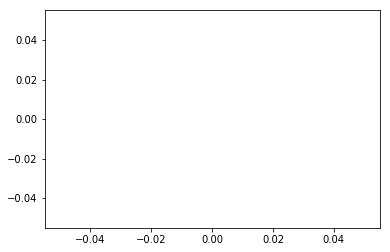

In [13]:
for organ in organs:
    print(organ)
    organ_data = combined[combined.obs['tissue']==organ]
    if organ=='Skin':
        organ_data = organ_data[organ_data.obs['method']=='smartseq2']
    organ_data = organ_data[organ_data.obs['manual_cell_ontology_class']!='low_quality']
    sc.pp.filter_genes(organ_data, min_cells=1)
    train_data = scVIdata_preprocess(organ_data, 'donor_tech', 'manual_cell_ontology_class')
    train_data.filter_genes_by_count(per_batch=True)
    if train_data.X.shape[0]>10000:
        train_data.subsample_genes(train_data.X.shape[0]//5)
    else:
        train_data.subsample_genes(train_data.X.shape[0]//2)
    posterior = get_scvi_posterior(train_data, 
                               model_path+'combined.%s.scVI.subsample_genes.pkl'%organ, 
                               retrain=retrain, n_epochs=100)


    full, pred_celltype = scanvi_pred(train_data, 
                                      model_path+'combined.%s.scVI.subsample_genes.pkl'%organ,
                                      model_path+'combined.%s.scANVI.subsample_genes.pkl'%organ,
                                      nlabels=30, retrain=retrain)

    pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])
    assert np.sum(pred_celltype=='unassigned')==0
    labels.loc[organ_data.obs.index,'pred'] = pred_celltype
    print(np.unique(pred_celltype), train_data.cell_types)

In [18]:
labels['pred'].fillna('unassigned', inplace=True)

In [19]:
np.unique(combined.obs.loc[labels['pred']=='unassigned','tissue'])

array(['Bladder', 'Bone_Marrow', 'Kidney', 'Lung', 'Lymph_Node', 'Muscle',
       'Pancreas', 'Skin', 'Small_Intestine', 'Spleen', 'Thymus',
       'Trachea', 'Vasculature'], dtype=object)

In [23]:
np.sum(labels['pred']=='unassigned')

5982

In [24]:
np.sum([x == 'low_quality' for x in combined.obs['manual_cell_ontology_class']])

5980

In [25]:
np.sum([x in ['Fat', 'Heart', "Skin"] for x in combined.obs['tissue']])

858

In [26]:
combined.obs['propagated_cell_ontology_class'] = labels.loc[combined.obs.index, 'pred']

In [27]:
combined.write_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.ss2_norm.embedding_donor_tech.propagated.subsample_genes.h5ad')

... storing 'manual_cell_ontology_class' as categorical
... storing 'propagated_cell_ontology_class' as categorical


In [28]:
combined.obs.to_csv(data_path + 'combined/annotation.subsample_genes.csv')